In [12]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.linalg import svd, expm
import time
from numpy import linalg as LA

In [30]:
# Define functions

def syssim(M, N, dim_lat, nu):
    x = np.zeros((dim_lat + nu, 1))
    rho = 5  # Increasing rho increases excitation for better operator recovery
    Sigma = rho * np.eye(dim_lat + nu) + np.random.rand(dim_lat + nu, dim_lat + nu)
    Sigma_symm = ((1 / 2) * (Sigma + Sigma.T))
    Sigma_symm = ((dim_lat + nu) / np.trace(Sigma_symm)) * Sigma_symm
    X=[]
    Y=[]
    for i in range(N):
        X.append(sqrtm(Sigma_symm).dot(np.random.normal(0, 1, dim_lat + nu))) 
        w = np.random.normal(0, 1, 1)
        Y.append(M.dot(X[i]) + w)

    return X, Y


def subspace_distance(Phi_1, Phi_2):
    r = Phi_1.shape[0]
    distance = np.sqrt(r - np.linalg.norm(Phi_1.dot(Phi_2.T), 'fro') ** 2)
    return distance


def tasksgen(nx, nu, r, dim_lat, H, scale):
    # True representation
    Phi, _, _ = svd(np.random.randn(dim_lat + nu, dim_lat + nu))
    Phi = Phi[:r, :]

    F_0 = np.random.randn(1, nu + nx)  # Nominal task weights F
    M_0 = F_0.dot(Phi)  # Nominal operator M

    # Generating different tasks weights
    F = []
    P = []
    for h in range(1, H + 1):
        L = scale * np.random.randn(1, 1)
        skewL = (L - L.T) / 2
        P.append(expm(skewL))
        F.append(P[h - 1].dot(F_0))  # Generating the true weights for H different tasks

    M = []
    for h in range(H):
        M.append(F[h].dot(Phi))  # Generating the true operators M for H different tasks
    return M, Phi



def grad_F(F,Phi,X,Y,sigma_F):
    
    M = len(F)
    T = len(X)
    
    sigma = 1
    sum_term = 0
    
    for t in range(T):
        sum_term = sum_term + (1/(sigma**2))*(Y[t] - np.dot(np.dot(F,Phi),X[t]))*(np.dot(Phi,X[t])).T
    
    grad_weight = -(F)/(sigma_F**2) + sum_term
    
    return grad_weight


def grad_Phi(F,Phi,Xc,Yc,sigma_phi1, sigma_phi2):
    
    M = len(F)
    T = len(Xc)
    
    sum_term = 0
    sigma = 1
    
    for i in range(M): 
        for t in range(T):
            X = np.zeros([Xc[i][t].shape[0],1])
            X[:,0] = Xc[i][t]
            sum_term = sum_term + (1/(sigma**2))*(Yc[i][t] - np.dot(np.dot(F[i],Phi),X))*(np.dot(X,F[i]).T)

    grad_phi=-Phi/((sigma_phi1**3)*(sigma_phi2**3)) + sum_term
    
    return grad_phi

def log_joint(F,Phi_hat,Yc,Xc,sigma_phi1,sigma_phi2,sigma_F):
    
    M = len(F)
    T = len(Xc)
    
    sigma = 1
    
    sum_term = 0
    
    for i in range(M):
        for t in range(T):
            X = np.zeros([Xc[i][t].shape[0],1])
            X[:,0] = Xc[i][t]
            sum_term = sum_term  - (1/2*(sigma**2))*(Yc[i][t] - np.dot(np.dot(F[i],Phi),X))**2
        sum_term = sum_term -(LA.norm(F[i], 'fro')**2)/(2*(sigma_F)**2)
    
    Log_joint_it = sum_term - (1/2)*((sigma_phi1**3)*(sigma_phi2**3))*(LA.norm(Phi_hat, 'fro')**2)
    
    return Log_joint_it[0][0]



def CAMAP(Phi_hat, K, H, M, Phi_true, nx, nu, N, dim_lat, sigma_phi1, sigma_phi2, sigma_F):
    
    eta_F = 0.001
    eta_phi = 0.001
    
    # Define the covariance matrix Sigma
    # Example covariance matrix
    Sigma = (sigma_F**2)*np.eye(nx+nu)

    # Generate uncorrelated random variables (standard normal distribution)
    dim = Sigma.shape[0]
    uncorrelated = np.random.randn(dim, 1)

    # Cholesky decomposition
    L = np.linalg.cholesky(Sigma)

    # Transform uncorrelated variables to have covariance matrix Sigma
    F_i = L.dot(uncorrelated)
    
    F = [0*F_i.T for _ in range(H)]
    
    
    
    Error_rep = []
    Log_joint_iter = []
    
    Phi = [Phi_hat.copy() for _ in range(H)]
    for k in range(K):
        start_time = time.time()
        # Calculating subspace distance
        Error_rep.append(subspace_distance(Phi_true, Phi_hat))
        

        # Initializing all the tasks with the same representation
        for h in range(H):
            Phi[h] = Phi_hat
        
        Xc=[]
        Yc=[]
        for h in range(H):
            if k == 0:
                # Sample a fresh data-set
                X, Y = syssim(M[h], N, dim_lat, nu)

            
            F[h] = F[h] + eta_F*grad_F(F[h],Phi[h],X,Y,sigma_F)
            Xc.append(X)
            Yc.append(Y)
        
        Log_joint_iter.append(log_joint(F,Phi_hat,Yc,Xc,sigma_phi1,sigma_phi2,sigma_F))
        
        Phi_hat = Phi_hat + (eta_phi/np.sqrt(k+1))*grad_Phi(F,Phi_hat,Xc,Yc,sigma_phi1, sigma_phi2)
        
        
        end_time = time.time()
        print(f"Iteration: {k}, Subspace Dist: {Error_rep[k]}, Log-joint: {Log_joint_iter[k]}, Time: {end_time - start_time}")
        
    return Error_rep, Log_joint_iter, Phi_hat, Phi


$\textbf{System Parameter:}$

In [26]:
# System dimensions
nx = 5
nu = 2
r = nx + nu  # rank
dim_lat = 50  # dimension of the latent space
H = 20  # number of tasks
scale = 0.001  # scale of rotation

M, Phi_true = tasksgen(nx, nu, r, dim_lat, H, scale)

np.save('seed', {"M_list": M, "Phi_true": Phi_true})

K = 100  # number of global iterations
N = 100  # number of samples


sigma_phi1 = 4
sigma_phi2 = 4
sigma_F = 4

In [27]:
#Initializing the representation
L = np.random.randn(dim_lat + nu, dim_lat + nu)
skewL = (L - L.T) / 2
rot = expm(skewL)
Phi_hat = Phi_true.dot(rot)

$\textbf{Coordinate Ascent MAP Estimation:}$

In [31]:
Error_CAMAP, Log_joint, Phi, F = CAMAP(Phi_hat, K, H, M, Phi_true, nx, nu, N, dim_lat, sigma_phi1, sigma_phi2, sigma_F)

Iteration: 0, Subspace Dist: 2.4652395894086068, Log-joint: -15261.250412986246, Time: 2.132032871246338
Iteration: 1, Subspace Dist: 2.455841592250131, Log-joint: -15457.847706172004, Time: 0.032227277755737305
Iteration: 2, Subspace Dist: 2.4340465836781653, Log-joint: -15379.404149526361, Time: 0.037747859954833984
Iteration: 3, Subspace Dist: 2.3879010177688174, Log-joint: -15845.854683468448, Time: 0.03513789176940918
Iteration: 4, Subspace Dist: 2.317660545367944, Log-joint: -16967.639036545334, Time: 0.033817291259765625
Iteration: 5, Subspace Dist: 2.2515891284636207, Log-joint: -18140.227885579196, Time: 0.030432939529418945
Iteration: 6, Subspace Dist: 2.205998691120625, Log-joint: -18959.439136302517, Time: 0.02657341957092285
Iteration: 7, Subspace Dist: 2.173475986275835, Log-joint: -19518.97554036292, Time: 0.03392910957336426
Iteration: 8, Subspace Dist: 2.1469870852421273, Log-joint: -19942.617465096126, Time: 0.02587437629699707
Iteration: 9, Subspace Dist: 2.123363444

Iteration: 79, Subspace Dist: 1.0556542288847457, Log-joint: -33276.92704553919, Time: 0.029644250869750977
Iteration: 80, Subspace Dist: 1.042069681759817, Log-joint: -33393.199432635, Time: 0.024933338165283203
Iteration: 81, Subspace Dist: 1.0284296339708625, Log-joint: -33508.48033029562, Time: 0.028723955154418945
Iteration: 82, Subspace Dist: 1.0147290636462003, Log-joint: -33622.79307362573, Time: 0.02892470359802246
Iteration: 83, Subspace Dist: 1.0009627503861804, Log-joint: -33736.16026092041, Time: 0.027415037155151367
Iteration: 84, Subspace Dist: 0.9871252548563502, Log-joint: -33848.603776443204, Time: 0.029163599014282227
Iteration: 85, Subspace Dist: 0.9732108962801033, Log-joint: -33960.14481294849, Time: 0.030376434326171875
Iteration: 86, Subspace Dist: 0.9592137275332062, Log-joint: -34070.80389388855, Time: 0.029666900634765625
Iteration: 87, Subspace Dist: 0.9451275074929958, Log-joint: -34180.60089525401, Time: 0.030391454696655273
Iteration: 88, Subspace Dist: 0

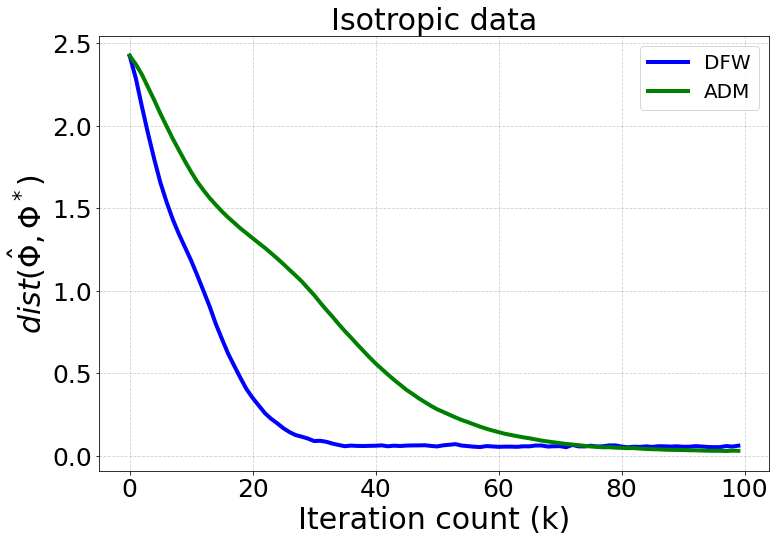

In [19]:
# Create a plot to show the convergence of the Gibbs Sampler (Log-joint vs iterations)
fig, ax = plt.subplots(figsize=(12,8))


# Plot the data
ax.plot(list(range(int(K))), Error_CAMAP, color='blue', linestyle='-', linewidth=4)

# Set labels and a title
ax.set_xlabel('Iteration count (k)',fontsize=30)
ax.set_ylabel(r'$dist(\hat{\Phi},\Phi^*)$',fontsize=30)
ax.tick_params(axis='both', labelsize=25)
ax.set_title(r'Non-isotropic data',fontsize=30)


# Customize the grid
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()